In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ShuffleSplit
import lightgbm as lgb
import numpy as np
import pandas as pd
from Processing.load_dataset import Load_dataset

from Engineering.dummy import engin
from Valid.validation import rmse

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter('ignore', category=UserWarning)
import matplotlib.pyplot as plt

In [8]:
train, test = Load_dataset()

# 提出用
index = np.array(test["id"])

# 加工・処理
train_df = engin(train)
test_df = engin(test)

# Train
y = train_df["pm25_mid"]
X = train_df.drop(["id","pm25_mid"], axis=1)

In [9]:
FOLD = 10
NUM_ROUND = 1000
VERBOSE_EVAL = -1

params = {
    'objective': 'regression',
    'verbose': -1,
}

valid_scores = []
models = []
ss = ShuffleSplit(n_splits=FOLD, test_size=0.25, random_state=123)

for fold, (train_indices, valid_indices) in enumerate(ss.split(X)):
    X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices]
    y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=NUM_ROUND,
        verbose_eval=VERBOSE_EVAL
    )

    y_valid_pred = model.predict(X_valid)
    MSE = mean_squared_error(y_valid, y_valid_pred)
    r2 = r2_score(y_valid, y_valid_pred)
    MAE = mean_absolute_error(y_valid, y_valid_pred)
    
    print(f'fold {fold} MSE: {MSE} RMSE: {np.sqrt(MSE)} R^2: {r2} MAE: {MAE}')
    valid_scores.append(np.sqrt(MSE))
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

fold 0 MSE: 385.83560105865564 RMSE: 19.64269841591668 R^2: 0.7401268043192692 MAE: 14.185823163120876
fold 1 MSE: 388.533743790978 RMSE: 19.71125931519795 R^2: 0.7383458074126071 MAE: 14.212931905301742
fold 2 MSE: 382.6706981160091 RMSE: 19.56197071145975 R^2: 0.740881548277617 MAE: 14.064482676696507
fold 3 MSE: 382.3337228146993 RMSE: 19.553355794203185 R^2: 0.7412711260380513 MAE: 14.120032738350739
fold 4 MSE: 390.3636827444643 RMSE: 19.757623408306586 R^2: 0.7375867498800606 MAE: 14.201905645999938
fold 5 MSE: 382.23245296722854 RMSE: 19.550766045534598 R^2: 0.7427870052520198 MAE: 14.070720125967608
fold 6 MSE: 384.76773619701896 RMSE: 19.615497347684535 R^2: 0.7414423512690207 MAE: 14.132158194831247
fold 7 MSE: 384.3657762898046 RMSE: 19.60524869237329 R^2: 0.7373761245625985 MAE: 14.17157785531047
fold 8 MSE: 389.3498831294871 RMSE: 19.731950819153365 R^2: 0.7370865562600524 MAE: 14.230687802669399
fold 9 MSE: 380.2208281015758 RMSE: 19.4992519882578 R^2: 0.7423517698544695 

In [4]:
test_df = engin(test)
test_df = test_df.drop(["id"], axis=1)

predict = models[0].predict(test_df)

## 正則化

In [11]:
from sklearn import preprocessing

In [14]:
train.columns

Index(['id', 'year', 'month', 'day', 'Country', 'City', 'lat', 'lon', 'co_cnt',
       'co_min', 'co_mid', 'co_max', 'co_var', 'o3_cnt', 'o3_min', 'o3_mid',
       'o3_max', 'o3_var', 'so2_cnt', 'so2_min', 'so2_mid', 'so2_max',
       'so2_var', 'no2_cnt', 'no2_min', 'no2_mid', 'no2_max', 'no2_var',
       'temperature_cnt', 'temperature_min', 'temperature_mid',
       'temperature_max', 'temperature_var', 'humidity_cnt', 'humidity_min',
       'humidity_mid', 'humidity_max', 'humidity_var', 'pressure_cnt',
       'pressure_min', 'pressure_mid', 'pressure_max', 'pressure_var',
       'ws_cnt', 'ws_min', 'ws_mid', 'ws_max', 'ws_var', 'dew_cnt', 'dew_min',
       'dew_mid', 'dew_max', 'dew_var', 'pm25_mid'],
      dtype='object')

In [33]:
col = ['co_min', 'co_mid', 'co_max', 'o3_min', 'o3_mid',
       'o3_max', 'so2_min', 'so2_mid', 'so2_max', 'no2_min', 'no2_mid', 'no2_max',
       'ws_min', 'ws_mid', 'ws_max']

In [36]:
# 標準化変換
ss = preprocessing.StandardScaler()
df_std = pd.DataFrame(ss.fit_transform(train[col]), 
                      index = train.index, columns = col)
df_std.head()

,co_min,co_mid,co_max,o3_min,o3_mid,o3_max,so2_min,so2_mid,so2_max,no2_min,no2_mid,no2_max,ws_min,ws_mid,ws_max
0,-0.430249,-0.367334,-0.519897,-0.434448,-1.331752,-1.303355,-0.494064,-0.662577,-0.566745,-0.823781,-1.281168,-1.251107,-0.519852,-0.854680,-0.745613
1,0.283644,-0.236282,-0.382973,-0.338757,-1.052218,-1.081284,-0.513727,-0.744726,0.092795,-0.793215,-1.313609,-1.103885,0.318344,0.736420,0.214656
2,-0.259611,-0.676228,-0.546908,-0.663143,-0.629547,-0.697091,-0.032901,-0.439023,1.454945,-0.523674,-0.965012,-0.792403,-0.863983,-0.174877,0.369595
3,1.054416,1.507316,0.239205,-0.500537,-0.491870,-0.179918,0.547727,-0.042642,0.002158,3.794844,1.129415,-0.244671,-0.458450,-1.244950,-0.635836
4,1.094270,0.983328,0.008274,-0.716427,-1.497749,-0.172096,-0.392779,0.532852,-0.174446,3.780024,1.651457,0.137339,-0.150017,-1.076834,-0.679657


In [38]:
# 正規化
mm = preprocessing.MinMaxScaler()
df_mm = pd.DataFrame(ss.fit_transform(train[col]), index = train.index, columns = col)
df_mm.head()

,co_min,co_mid,co_max,o3_min,o3_mid,o3_max,so2_min,so2_mid,so2_max,no2_min,no2_mid,no2_max,ws_min,ws_mid,ws_max
0,-0.430249,-0.367334,-0.519897,-0.434448,-1.331752,-1.303355,-0.494064,-0.662577,-0.566745,-0.823781,-1.281168,-1.251107,-0.519852,-0.854680,-0.745613
1,0.283644,-0.236282,-0.382973,-0.338757,-1.052218,-1.081284,-0.513727,-0.744726,0.092795,-0.793215,-1.313609,-1.103885,0.318344,0.736420,0.214656
2,-0.259611,-0.676228,-0.546908,-0.663143,-0.629547,-0.697091,-0.032901,-0.439023,1.454945,-0.523674,-0.965012,-0.792403,-0.863983,-0.174877,0.369595
3,1.054416,1.507316,0.239205,-0.500537,-0.491870,-0.179918,0.547727,-0.042642,0.002158,3.794844,1.129415,-0.244671,-0.458450,-1.244950,-0.635836
4,1.094270,0.983328,0.008274,-0.716427,-1.497749,-0.172096,-0.392779,0.532852,-0.174446,3.780024,1.651457,0.137339,-0.150017,-1.076834,-0.679657


In [48]:
# 対数変換＋標準化
logs = lambda x: np.log(x+1)
df_log = train[col].apply(logs)
ss = preprocessing.StandardScaler()
df_log_std = pd.DataFrame(ss.fit_transform(df_log), 
                          index = df_log.index, columns = df_log.columns)
df_log_std.head()

,co_min,co_mid,co_max,o3_min,o3_mid,o3_max,so2_min,so2_mid,so2_max,no2_min,no2_mid,no2_max,ws_min,ws_mid,ws_max
0,-0.516530,-0.175482,-0.740368,-0.203975,-1.677973,-2.963436,-1.432064,-1.698969,-1.668386,-1.914289,-2.767226,-2.996347,-0.584179,-0.958104,-1.017693
1,0.712319,0.030221,-0.269227,-0.004996,-0.991203,-1.826380,-1.538214,-2.226021,0.675939,-1.750439,-3.023904,-1.975298,0.584971,0.897173,0.507578
2,-0.132876,-0.838299,-0.866881,-0.921584,-0.340860,-0.776991,0.216081,-0.747167,1.786780,-0.735674,-1.340769,-0.916467,-1.235965,0.009776,0.676405
3,1.464754,1.458299,0.725127,-0.366819,-0.180168,0.049754,1.347507,0.246044,0.537066,2.893602,1.193224,0.026491,-0.481355,-1.758666,-0.776969
4,1.495928,1.163507,0.459028,-1.191200,-2.331045,0.059669,-0.952903,1.116894,0.199918,2.888374,1.481221,0.445031,-0.011996,-1.381193,-0.869824


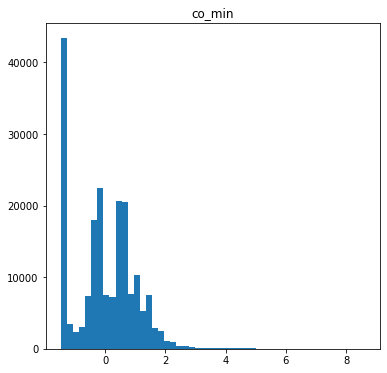

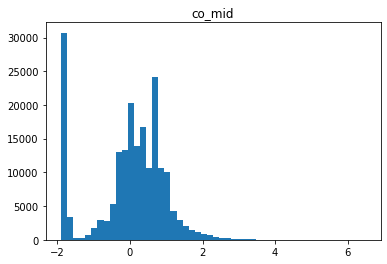

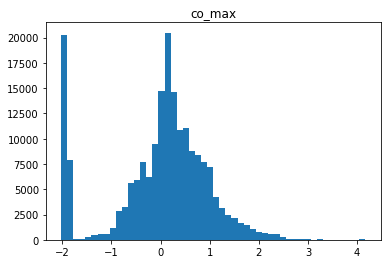

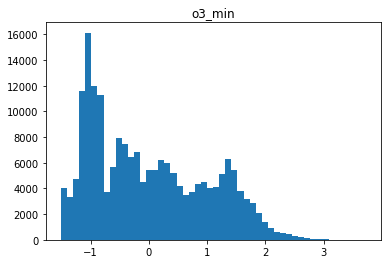

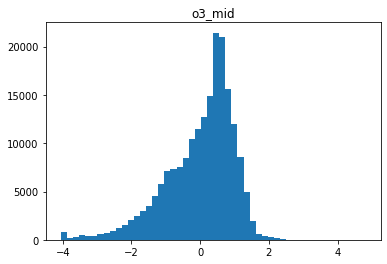

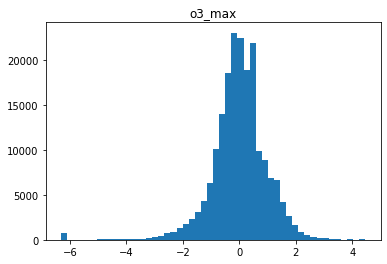

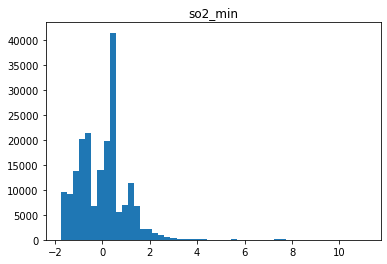

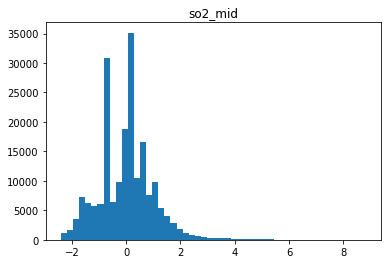

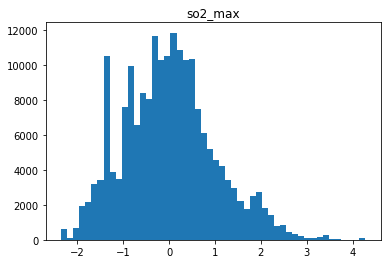

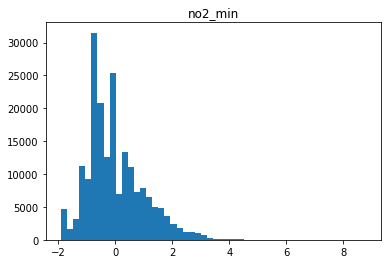

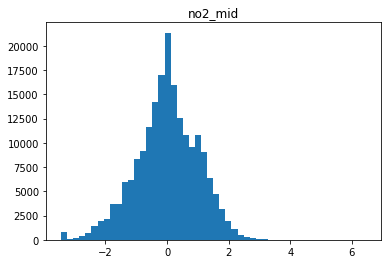

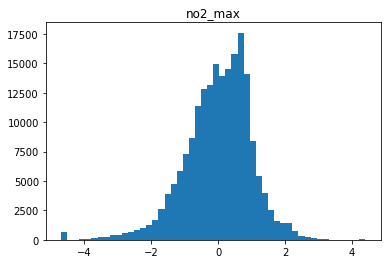

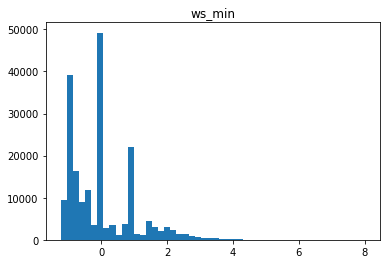

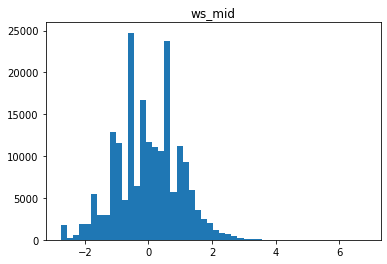

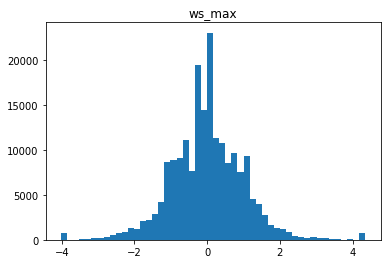

In [49]:
plt.figure(figsize=(6,6))
for col in df_log_std.columns:
#     bins = np.linspace(-10, 10, 100)
    plt.hist(df_log_std[col], bins=50)
    plt.title(col)
    plt.show()

In [100]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [101]:
train, test = Load_dataset()

# 提出用
index = np.array(test["id"])

# 加工・処理
train_df = engin(train)
test_df = engin(test)

# Train
y = train_df["pm25_mid"]
X = train_df.drop(["id","pm25_mid"], axis=1)

X_no = X
y_no = y

In [102]:
col = ['co_min', 'co_mid', 'co_max', 'o3_min', 'o3_mid',
       'o3_max', 'so2_min', 'so2_mid', 'so2_max', 'no2_min', 'no2_mid', 'no2_max',
       'ws_min', 'ws_mid', 'ws_max']

# 標準化変換
ss = preprocessing.StandardScaler()
X_std = pd.DataFrame(ss.fit_transform(X[col]), 
                      index = X.index, columns = col)

# 正規化
mm = preprocessing.MinMaxScaler()
X_mm = pd.DataFrame(ss.fit_transform(X[col]), 
                     index = X.index, columns = col)

# 対数変換＋標準化
logs = lambda x: np.log(x+1)
X_log = X[col].apply(logs)
ss = preprocessing.StandardScaler()
X_log_std = pd.DataFrame(ss.fit_transform(X_log), 
                          index = X_log.index, columns = X_log.columns)

X = X.drop(col, axis=1)

X_std = pd.concat([X, X_std], axis=1)
X_mm = pd.concat([X, X_mm], axis=1)
X_log_std = pd.concat([X, X_log_std], axis=1)

In [103]:
### クロスバリデーションで精度検証する関数を定義 ###
def predict_cv(df, target, model):
    kf = KFold(n_splits = 10, shuffle = True, random_state = 123)
    rmse_list = []

    for fold, (tr_idx, va_idx) in enumerate(kf.split(df)):
        X_train, X_test = X.iloc[tr_idx], X.iloc[va_idx]
        y_train, y_test = y.iloc[tr_idx], y.iloc[va_idx]

        model.fit(X_train.values, y_train.values.ravel())
        y_valid_pred = model.predict(X_test.values)

        # 精度(RMSE)
        MSE = mean_squared_error(y_test, y_valid_pred)
        r2 = r2_score(y_test, y_valid_pred)
        MAE = mean_absolute_error(y_test, y_valid_pred)

        print(f'fold {fold} MSE: {MSE} RMSE: {np.sqrt(MSE)} R^2: {r2} MAE: {MAE}')
        rmse_list.append(np.sqrt(mean_squared_error(y_test, y_valid_pred)))

    print("\n")
    return rmse_list

In [104]:
### 線形回帰 ###
# 無変換
rmse_lr = predict_cv(X_no, y, LinearRegression())
# 標準化
rmse_lr_std = predict_cv(X_std, y, LinearRegression())
# 正規化
rmse_lr_mm = predict_cv(X_mm, y, LinearRegression())
# 対数変換
rmse_lr_log_std = predict_cv(X_log_std, y, LinearRegression())

fold 0 MSE: 876.7180592304773 RMSE: 29.60942517561726 R^2: 0.3998891724468049 MAE: 21.535297997590497
fold 1 MSE: 897.4511126055545 RMSE: 29.957488422856056 R^2: 0.40529195230311466 MAE: 21.883536435177703
fold 2 MSE: 868.5107820531144 RMSE: 29.470506986699675 R^2: 0.4080913483519266 MAE: 21.53854196434208
fold 3 MSE: 880.5156609127873 RMSE: 29.67348413841535 R^2: 0.41676607146033695 MAE: 21.553546983017515
fold 4 MSE: 866.0557469701847 RMSE: 29.4288251034625 R^2: 0.4115888411966131 MAE: 21.641148785272556
fold 5 MSE: 913.1195377666725 RMSE: 30.217867856066093 R^2: 0.40540792051558006 MAE: 21.867204063952624
fold 6 MSE: 885.3643086537513 RMSE: 29.755071981995798 R^2: 0.4020880984431313 MAE: 21.635996741916127
fold 7 MSE: 875.4844548796071 RMSE: 29.58858656441039 R^2: 0.3960233101297168 MAE: 21.524211431769952
fold 8 MSE: 884.210781345127 RMSE: 29.735681955272643 R^2: 0.40714729703975727 MAE: 21.525714446455204
fold 9 MSE: 916.6453205824885 RMSE: 30.276151019944535 R^2: 0.38850967728727

In [105]:
### Elastic Net ###
seed = 123
rmse_en = predict_cv(X_no, y, ElasticNet(random_state = seed))
rmse_en_std = predict_cv(X_std, y, ElasticNet(random_state = seed))
rmse_en_mm = predict_cv(X_mm, y, ElasticNet(random_state = seed))
rmse_en_log_std = predict_cv(X_log_std, y, ElasticNet(random_state = seed))

fold 0 MSE: 1006.2328186797264 RMSE: 31.721173034421764 R^2: 0.31123671610107617 MAE: 22.89785482922216
fold 1 MSE: 1038.0237508881942 RMSE: 32.21837598154497 R^2: 0.31213960327993995 MAE: 23.301470713186482
fold 2 MSE: 997.2998586690549 RMSE: 31.58005476038721 R^2: 0.3203188413641208 MAE: 22.817475816869866
fold 3 MSE: 1013.305790357758 RMSE: 31.832464409117904 R^2: 0.3288088524062267 MAE: 22.887346997936376
fold 4 MSE: 990.3290344718047 RMSE: 31.469493711717142 R^2: 0.32715572085424327 MAE: 22.868455275344637
fold 5 MSE: 1058.054144484975 RMSE: 32.527744226813134 R^2: 0.3110314827835984 MAE: 23.348826716381264
fold 6 MSE: 1015.6271670638824 RMSE: 31.868905959632226 R^2: 0.31411785544489645 MAE: 22.865989166028545
fold 7 MSE: 1007.9829683351296 RMSE: 31.748747508132183 R^2: 0.3046156179387637 MAE: 22.9030497751237
fold 8 MSE: 1023.6561880535621 RMSE: 31.99462748733859 R^2: 0.3136508276156664 MAE: 22.908468404643866
fold 9 MSE: 1057.371845264387 RMSE: 32.51725457759906 R^2: 0.294631591

In [ ]:
rmse_nn = predict_cv(X_no, y, 
                     MLPRegressor(hidden_layer_sizes = (30, 30, ), random_state = 1, max_iter = 10000, early_stopping = True))
rmse_nn_std = predict_cv(X_std, y,
                         MLPRegressor(hidden_layer_sizes = (30, 30, ), random_state = 1, max_iter = 10000, early_stopping = True))
rmse_nn_mm = predict_cv(X_mm, y, 
                        MLPRegressor(hidden_layer_sizes = (30, 30, ), random_state = 1, max_iter = 10000, early_stopping = True))
rmse_nn_log_std = predict_cv(X_log_std, v,
                             MLPRegressor(hidden_layer_sizes = (30, 30, ), random_state = 1, max_iter = 10000, early_stopping = True))

In [109]:
X_no

,co_cnt,co_min,co_mid,co_max,o3_cnt,o3_min,o3_mid,o3_max,so2_cnt,so2_min,...,Vietnam,co_std,o3_std,so2_std,no2_std,temperature_std,humidity_std,pressure_std,ws_std,dew_std
0,38,0.749,2.590,2.633,29,2.397,4.295,5.916,11,0.149,...,0,0.921954,1.736951,0.370135,1.080278,4.886717,31.528574,9.465094,1.408190,3.663878
1,47,2.594,3.181,4.828,49,3.092,7.572,12.332,31,0.096,...,0,1.099091,4.530342,7.845381,2.530020,6.109583,21.612774,2.705550,3.226608,1.421619
2,17,1.190,1.197,2.200,123,0.736,12.527,23.432,36,1.392,...,0,0.497996,11.190353,22.706167,5.524310,11.457748,35.947058,68.230111,3.964719,2.520913
3,63,4.586,11.044,14.802,90,1.917,14.141,38.374,50,2.957,...,0,4.917926,17.456546,5.062608,4.569792,1.785497,9.221063,3.301212,1.576388,3.068713
4,47,4.689,8.681,11.100,83,0.349,2.349,38.600,47,0.422,...,0,3.164016,18.802899,3.038750,8.619629,1.520197,22.004272,3.891272,1.391761,2.027067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195936,12,0.694,0.995,1.301,26,6.859,9.295,25.886,8,0.257,...,0,0.300000,9.364187,0.613188,0.424264,2.951271,20.621930,4.205948,1.938298,3.640330
195937,14,0.528,1.256,3.226,8,4.435,7.450,23.110,9,0.288,...,0,1.320227,9.204890,0.490918,2.323360,7.262300,28.591520,5.133030,2.890329,2.660451
195938,171,1.975,6.627,6.639,112,4.613,7.397,37.550,120,0.420,...,0,2.300652,8.447189,2.116365,11.907393,6.713345,15.683208,3.051721,0.782304,2.299130
195939,31,2.613,2.704,8.767,108,12.694,15.474,37.831,27,0.702,...,1,2.077739,12.236258,1.698234,11.994624,4.575915,8.856862,5.005397,2.466779,2.154530


In [ ]:
rmse_lgb = predict_cv(X_no, y, lgb.LGBMRegressor(seed = seed, objective="regression"))
rmse_lgb_std = predict_cv(X_std, y, lgb.LGBMRegressor(seed = seed, objective="regression"))
rmse_lgb_mm = predict_cv(X_mm, y, lgb.LGBMRegressor(seed = seed, objective="regression"))
rmse_lgb_log_std = predict_cv(X_log_std, y, lgb.LGBMRegressor(seed = seed, objective="regression"))

In [129]:
FOLD = 10
NUM_ROUND = 1000
VERBOSE_EVAL = -1

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'learning_rate': 0.1,
    'num_leaves': 63
}

valid_scores = []
models = []
ss = ShuffleSplit(n_splits=FOLD, test_size=0.25, random_state=123)

for fold, (train_indices, valid_indices) in enumerate(ss.split(X)):
    X_train, X_valid = X_no.iloc[train_indices], X_no.iloc[valid_indices]
    y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=NUM_ROUND,
        verbose_eval=VERBOSE_EVAL
    )

    y_valid_pred = model.predict(X_valid)
    MSE = mean_squared_error(y_valid, y_valid_pred)
    r2 = r2_score(y_valid, y_valid_pred)
    MAE = mean_absolute_error(y_valid, y_valid_pred)
    
    print(f'fold {fold} MSE: {MSE} RMSE: {np.sqrt(MSE)} R^2: {r2} MAE: {MAE}')
    valid_scores.append(np.sqrt(MSE))
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

fold 0 MSE: 383.0026860936541 RMSE: 19.570454417147655 R^2: 0.742034867398536 MAE: 14.090118473478519
fold 1 MSE: 385.422444900975 RMSE: 19.63217881186332 R^2: 0.7404410807626607 MAE: 14.087574898113514
fold 2 MSE: 379.6539880125342 RMSE: 19.484711648175196 R^2: 0.7429242582503328 MAE: 13.968793331189891
fold 3 MSE: 378.78196100940164 RMSE: 19.4623215729625 R^2: 0.7436746371008489 MAE: 14.019215657682237
fold 4 MSE: 387.1618831143805 RMSE: 19.676429633304423 R^2: 0.7397390880311306 MAE: 14.10981952781322
fold 5 MSE: 379.21105087142183 RMSE: 19.47334205706411 R^2: 0.7448201761022901 MAE: 13.985334557863142
fold 6 MSE: 382.5014929662849 RMSE: 19.557645383999702 R^2: 0.742965229790444 MAE: 14.039770768203207
fold 7 MSE: 380.3162514406591 RMSE: 19.501698680901082 R^2: 0.7401430251951897 MAE: 14.05716320535837
fold 8 MSE: 386.90363180546257 RMSE: 19.669866085092256 R^2: 0.7387384184737591 MAE: 14.138859613903405
fold 9 MSE: 376.0111355262336 RMSE: 19.391006562998054 R^2: 0.7452043748706364 

In [113]:
FOLD = 10
NUM_ROUND = 1000
VERBOSE_EVAL = -1

params = {
    'objective': 'regression',
    'verbose': -1,
}

valid_scores = []
models = []
ss = ShuffleSplit(n_splits=FOLD, test_size=0.25, random_state=123)

for fold, (train_indices, valid_indices) in enumerate(ss.split(X)):
    X_train, X_valid = X_log_std.iloc[train_indices], X_log_std.iloc[valid_indices]
    y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=NUM_ROUND,
        verbose_eval=VERBOSE_EVAL
    )

    y_valid_pred = model.predict(X_valid)
    MSE = mean_squared_error(y_valid, y_valid_pred)
    r2 = r2_score(y_valid, y_valid_pred)
    MAE = mean_absolute_error(y_valid, y_valid_pred)
    
    print(f'fold {fold} MSE: {MSE} RMSE: {np.sqrt(MSE)} R^2: {r2} MAE: {MAE}')
    valid_scores.append(np.sqrt(MSE))
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

fold 0 MSE: 385.3635765907363 RMSE: 19.630679473485788 R^2: 0.740444728602516 MAE: 14.161330999094137
fold 1 MSE: 387.80557684244343 RMSE: 19.692779815009445 R^2: 0.7388361842152205 MAE: 14.184385036621398
fold 2 MSE: 383.5768720569534 RMSE: 19.585118637806445 R^2: 0.7402679491969331 MAE: 14.085333219828987
fold 3 MSE: 383.6793040827871 RMSE: 19.58773351061289 R^2: 0.74036055837022 MAE: 14.123048759325714
fold 4 MSE: 391.5671736142809 RMSE: 19.788056337454694 R^2: 0.7367777300746885 MAE: 14.23129921986471
fold 5 MSE: 384.3557636194148 RMSE: 19.60499333382735 R^2: 0.7413581807569005 MAE: 14.123889286594506
fold 6 MSE: 384.7944087165623 RMSE: 19.61617721974805 R^2: 0.7414244277705304 MAE: 14.160679221591852
fold 7 MSE: 384.54865278439416 RMSE: 19.60991210547345 R^2: 0.7372511713625526 MAE: 14.189846526570095
fold 8 MSE: 388.3563881705532 RMSE: 19.706759961255763 R^2: 0.7377574263239961 MAE: 14.214577108847571
fold 9 MSE: 381.4606388420508 RMSE: 19.53101735297091 R^2: 0.7415116395423198 M

In [120]:
import xgboost as xgb

In [135]:
FOLD = 10
NUM_ROUND = 2000
VERBOSE_EVAL = -1

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate':0.01,
    'max_depth':6,
}

valid_scores = []
models = []
ss = ShuffleSplit(n_splits=FOLD, test_size=0.25, random_state=123)

for fold, (train_indices, valid_indices) in enumerate(ss.split(X)):
    X_train, X_valid = X_no.iloc[train_indices], X_no.iloc[valid_indices]
    y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(dtrain, 'train'), (dtest, 'eval')]

    model = xgb.train(params,
                      dtrain,
                      num_boost_round=NUM_ROUND,
                      evals=evals,
                      early_stopping_rounds=20,
                      verbose_eval=200
                      )
    dm_valid = xgb.DMatrix(X_valid)
    y_valid_pred = model.predict(dm_valid)
    MSE = mean_squared_error(y_valid, y_valid_pred)
    r2 = r2_score(y_valid, y_valid_pred)
    MAE = mean_absolute_error(y_valid, y_valid_pred)
    
    print(f'fold {fold} MSE: {MSE} RMSE: {np.sqrt(MSE)} R^2: {r2} MAE: {MAE}')
    valid_scores.append(np.sqrt(MSE))
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')

[0]	train-rmse:69.62786	eval-rmse:69.61725
[200]	train-rmse:24.13673	eval-rmse:24.53609
[400]	train-rmse:20.99738	eval-rmse:21.59218
[600]	train-rmse:20.29024	eval-rmse:21.03736
[800]	train-rmse:19.85941	eval-rmse:20.75350
[1000]	train-rmse:19.53435	eval-rmse:20.56893
[1200]	train-rmse:19.23770	eval-rmse:20.41746
[1400]	train-rmse:18.99636	eval-rmse:20.30726
[1600]	train-rmse:18.78271	eval-rmse:20.22230
[1800]	train-rmse:18.58481	eval-rmse:20.14853
[1999]	train-rmse:18.41629	eval-rmse:20.09446
fold 0 MSE: 403.787168128444 RMSE: 20.094456154084988 R^2: 0.7280358228517667 MAE: 14.5552546609241
[0]	train-rmse:69.63409	eval-rmse:69.59675
[200]	train-rmse:24.11729	eval-rmse:24.54728
[400]	train-rmse:20.99044	eval-rmse:21.68939
[600]	train-rmse:20.30206	eval-rmse:21.15642
[800]	train-rmse:19.85367	eval-rmse:20.86399
[1000]	train-rmse:19.52137	eval-rmse:20.66947
[1200]	train-rmse:19.23174	eval-rmse:20.51453
[1400]	train-rmse:18.99476	eval-rmse:20.40911
[1600]	train-rmse:18.77694	eval-rmse:20.

KeyboardInterrupt: 

In [ ]:
FOLD = 10
NUM_ROUND = 2000
VERBOSE_EVAL = -1

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate':0.01,
    'max_depth':6,
}

valid_scores = []
models = []
ss = ShuffleSplit(n_splits=FOLD, test_size=0.25, random_state=123)

for fold, (train_indices, valid_indices) in enumerate(ss.split(X)):
    X_train, X_valid = X_log_std.iloc[train_indices], X_log_std.iloc[valid_indices]
    y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(dtrain, 'train'), (dtest, 'eval')]

    model = xgb.train(params,
                      dtrain,
                      num_boost_round=NUM_ROUND,
                      evals=evals,
                      early_stopping_rounds=20,
                      verbose_eval=200
                      )

    y_valid_pred = model.predict(X_valid)
    MSE = mean_squared_error(y_valid, y_valid_pred)
    r2 = r2_score(y_valid, y_valid_pred)
    MAE = mean_absolute_error(y_valid, y_valid_pred)
    
    print(f'fold {fold} MSE: {MSE} RMSE: {np.sqrt(MSE)} R^2: {r2} MAE: {MAE}')
    valid_scores.append(np.sqrt(MSE))
    models.append(model)

cv_score = np.mean(valid_scores)
print(f'CV score: {cv_score}')